## Breast Cancer Proteomes Network Modelling

### Mathematical Modelling in Industry - Math Research, MSc

Setting up the env - Importing all needed libraries and configs for the notebook.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sn
import re
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import networkx as nx

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Data import

* **in_proteomes_77**: 77 breast cancer samples generated by the Clinical Proteomic Tumor Analysis Consortium (NCI/NIH). It contains expression values for ~12.000 proteins for each sample, with missing values present when a given protein could not be quantified in a given sample.
* **in_clinical_data**: data about the cancer classification of a given sample using different methods.
* **in_PAM50**: Contains the list of genes and proteins used by the PAM50 classification system

In [5]:
# Reading input data as pandas.
in_proteomes_77 = pd.read_csv('./77_cancer_proteomes_CPTAC_itraq.csv')
in_clinical_data = pd.read_csv('./clinical_data_breast_cancer.csv')
in_PAM50 = pd.read_csv('./PAM50_proteins.csv')

### Nature and size of the source inputs. First pre-processing of the data. Normalization stage.

In [6]:
in_clinical_data = in_clinical_data.set_index(['Complete TCGA ID'])
in_clinical_data.head()

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,M1,...,Basal-like,0,-13,3,5,Basal,3,2,2,2
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,T_Other,N3,Positive,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2


In [7]:
in_proteomes_77.head()

,RefSeq_accession_number,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
0,NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
1,NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
2,NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
3,NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
4,NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


__RefSeq_accession_number__ is a unique Protein ID, whereas all the *TCGA columns are unique IDs of Patients. We'll need to transpose the Dataframe as we will be working following a Patient based approach with Proteins as attributes. The columns __gene_symbol__ and __gene_name__ are not providing any useful information at this stage - we will get rid of these. 

In [8]:
in_proteomes_77.drop(['gene_symbol','gene_name'],axis=1,inplace=True)

# Naming normalization: will rename all the TCGAs codes as are found in clinical_data.
in_proteomes_77.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x, inplace=True)

# Transposing the DF
proteomes_base_df = in_proteomes_77.transpose()
proteomes_base_df = proteomes_base_df.rename(columns=proteomes_base_df.iloc[0]).drop(proteomes_base_df.index[0])

In [9]:
proteomes_base_df.head()

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-AO-A12D,1.09613,1.11137,1.11137,1.10756,1.11518,1.10756,1.11137,1.11137,-1.51739,0.482754,...,NaN,NaN,NaN,-0.340163,NaN,NaN,NaN,NaN,-0.633517,12.6665
TCGA-C8-A131,2.60994,2.65042,2.65042,2.64637,2.64637,2.64637,2.65042,2.65042,3.90931,-1.04529,...,NaN,NaN,NaN,3.4519,NaN,NaN,NaN,NaN,4.84033,0.140736
TCGA-AO-A12B,-0.659828,-0.648742,-0.654285,-0.632113,-0.640428,-0.654285,-0.648742,-0.648742,-0.618256,1.222,...,NaN,NaN,NaN,-1.71853,NaN,NaN,NaN,NaN,-1.96519,-2.85484
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.03576,-0.517226,...,0.0481439,NaN,-0.881872,2.52707,-8.11124,-16.0298,-2.04607,-1.77843,NaN,-3.06975
TCGA-C8-A130,-0.49406,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.84537,-0.405503,...,1.45746,NaN,1.71001,0.296389,-1.75353,1.72969,-0.425182,-0.149673,NaN,-0.0479974


In [10]:
master_df = proteomes_base_df.join(in_clinical_data, how='inner')

In [11]:
master_df.head()

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.65215,-0.984373,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.0975117,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.51247,...,Basal-like,-12,-13,4,5,Basal,3,2,2,2
TCGA-A2-A0EQ,-0.91267,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.07115,-2.27894,...,HER2-enriched,-5,-2,5,4,Basal,4,4,1,1
TCGA-A2-A0EV,0.452986,0.47259,0.47259,0.458587,0.47259,0.47259,0.47259,0.47259,-0.742871,1.81128,...,Luminal A,-4,0,4,2,ReacI,3,3,3,4
TCGA-A2-A0EX,1.18511,1.19261,1.18886,1.18511,1.20012,1.18886,1.18886,1.19261,1.04629,2.13808,...,Luminal A,-7,-5,4,4,ReacI,4,3,1,4


In [12]:
print("We have {} rows not being found within our base proteomes DF. Making, hence, a total of {} complete - with clinical and proteome data- records ".format(proteomes_base_df.size - master_df.size, master_df.size))

We have 35339 rows not being found within our base proteomes DF. Making, hence, a total of 1006560 complete - with clinical and proteome data- records 


In [13]:
proteomes_df = master_df.loc[:,[x for x in master_df.columns if bool(re.search("NP_|XP_",x)) == True]]

In [14]:
proteomes_df.isnull().sum().sum()

104030

In [15]:
from sklearn.impute import SimpleImputer

# replacing all Null values by the median computed by patient (not by proteome).
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp = imp.fit(proteomes_df)

clean_working_df = imp.transform(proteomes_df)

In [28]:
test = in_clinical_data.groupby(["PAM50 mRNA","Tumor"]).size()
test.head(30)

PAM50 mRNA     Tumor
Basal-like     T1        3
               T2       18
               T3        3
               T4        1
HER2-enriched  T1        3
               T2       11
               T3        4
Luminal A      T1        6
               T2       15
               T3        7
               T4        1
Luminal B      T1        3
               T2       21
               T3        5
               T4        4
dtype: int64

In [29]:
unsupervised_df = master_df.loc[:,[x for x in master_df.columns if bool(re.search("NP_|XP_|PAM50 ",x)) == True]]
unsupervised_df = unsupervised_df.replace(regex={'Basal-like': 1, 'HER2-enriched': 2, 'Luminal A': 3, 'Luminal B': 4})

In [30]:
X = unsupervised_df.drop('PAM50 mRNA', axis=1)
y = unsupervised_df['PAM50 mRNA']

In [31]:
X.isnull().sum()

NP_958782        0
NP_958785        0
NP_958786        0
NP_000436        0
NP_958781        0
                ..
NP_001191293    34
NP_775791       58
NP_004065       57
NP_068752       55
NP_219494       54
Length: 12546, dtype: int64

In [32]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X)

unsupervised_df = imp.transform(X)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(unsupervised_df, y, test_size = 0.35)

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf', 'sigmoid', 'poly'), 'C':[1, 10, 100, 1000], 'degree':[3,5,8,10] }

svclassifier = SVC()
g_search_svc = GridSearchCV(svclassifier, parameters)
g_search_svc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000], 'degree': [3, 5, 8, 10],
                         'kernel': ('linear', 'rbf', 'sigmoid', 'poly')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [35]:
y_pred = g_search_svc.predict(X_test)

In [36]:
g_search_svc.best_params_

{'C': 100, 'degree': 3, 'kernel': 'sigmoid'}

In [37]:
def getStats(y_test, y_pred):
    %matplotlib inline
    import seaborn as sn
    from sklearn.metrics import classification_report, confusion_matrix
    
    cm = confusion_matrix(y_test, y_pred)
    
    print(classification_report(y_test, y_pred))
    sn.heatmap(cm, annot=True)

              precision    recall  f1-score   support

           1       0.89      0.80      0.84        10
           2       0.29      0.67      0.40         3
           3       0.43      0.75      0.55         4
           4       0.80      0.36      0.50        11

    accuracy                           0.61        28
   macro avg       0.60      0.65      0.57        28
weighted avg       0.72      0.61      0.62        28



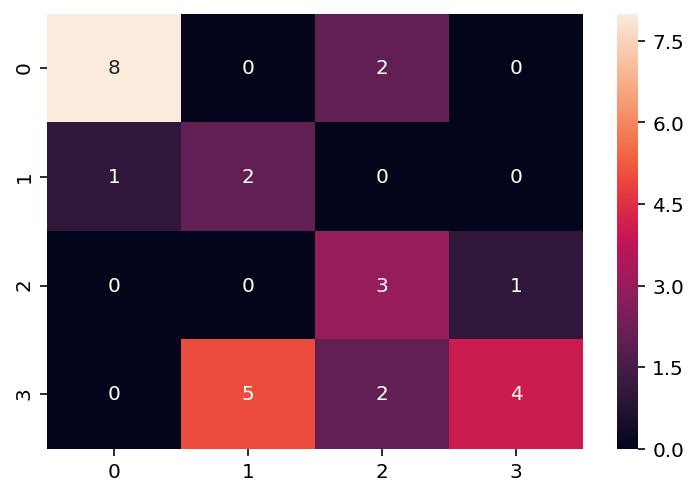

In [38]:
getStats(y_test, y_pred)

In [39]:
def applyClassifier(clf, param_grid, x_train, y_train, x_test):
    from sklearn.model_selection import GridSearchCV
    
    g_search = GridSearchCV(clf, param_grid, cv=5)
    g_search.fit(x_train, y_train)
    
    return g_search.predict(x_test), g_search.best_params_

In [40]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(1, 25), 'weights':['uniform','distance']}

g_search_knn = GridSearchCV(knn, param_grid, cv=5)

g_search_knn.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [41]:
y_pred = g_search_knn.predict(X_test)
g_search_knn.best_params_

{'n_neighbors': 11, 'weights': 'uniform'}

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
    
svc = SVC()
knn = KNeighborsClassifier()
rfr = RandomForestRegressor()

### SVC

In [43]:
kernel_list = ('linear', 'rbf', 'sigmoid', 'poly')
C = [1, 10, 100, 1000]
degree = [3,5,8,10]

param_grid = {'kernel': kernel_list, 
              'C': C, 
              'degree': degree }

y_pred, best_params = applyClassifier(svc, param_grid, X_train, y_train, X_test)

In [44]:
print(best_params)

{'C': 100, 'degree': 3, 'kernel': 'sigmoid'}


              precision    recall  f1-score   support

           1       0.89      0.80      0.84        10
           2       0.29      0.67      0.40         3
           3       0.43      0.75      0.55         4
           4       0.80      0.36      0.50        11

    accuracy                           0.61        28
   macro avg       0.60      0.65      0.57        28
weighted avg       0.72      0.61      0.62        28



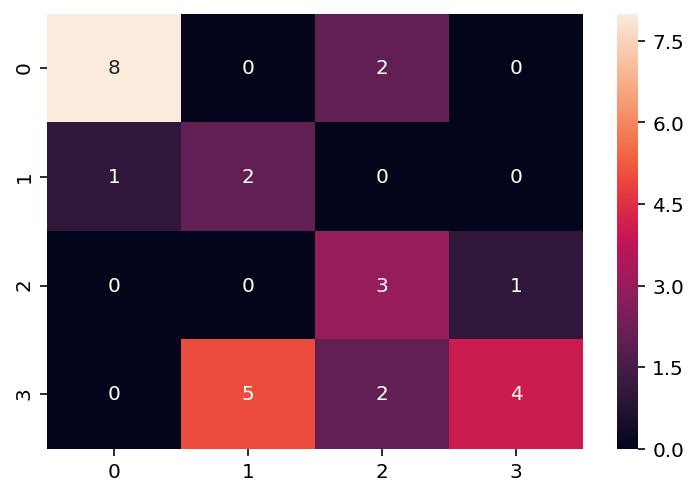

In [45]:
getStats(y_test, y_pred)

### Random Forest

In [46]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 50, num = 1)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [3, 5, 6, 8]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [47]:
y_pred, best_params = applyClassifier(rfr, param_grid, X_train, y_train, X_test)

KeyboardInterrupt: 

In [ ]:
print(best_params)

## Graph Modelling

In [16]:
def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

In [17]:

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(clean_working_df)

df = pd.DataFrame(imp.transform(clean_working_df))

In [18]:
correl = df.corr()

In [19]:
correl.head()

,0,1,2,3,4,5,6,7,8,9,...,12536,12537,12538,12539,12540,12541,12542,12543,12544,12545
0,1.000000,0.999923,0.999931,0.999909,0.999922,0.999934,0.999937,0.999938,0.460346,0.275906,...,0.072277,-0.017624,0.082420,0.165656,0.128253,0.049825,-0.027557,0.009441,0.343332,0.192873
1,0.999923,1.000000,0.999994,0.999952,0.999981,0.999992,0.999993,0.999993,0.463441,0.276983,...,0.069796,-0.021124,0.075778,0.163644,0.125846,0.045023,-0.030302,0.004914,0.343450,0.190629
2,0.999931,0.999994,1.000000,0.999952,0.999982,0.999991,0.999993,0.999993,0.463757,0.276101,...,0.069245,-0.020943,0.076801,0.164386,0.126356,0.045114,-0.030596,0.005324,0.343504,0.190539
3,0.999909,0.999952,0.999952,1.000000,0.999955,0.999961,0.999965,0.999965,0.463682,0.276370,...,0.068710,-0.017317,0.076518,0.163530,0.127812,0.046964,-0.031246,0.008219,0.342730,0.191420
4,0.999922,0.999981,0.999982,0.999955,1.000000,0.999985,0.999985,0.999985,0.463074,0.276899,...,0.069343,-0.020541,0.075836,0.163571,0.126938,0.045605,-0.029236,0.006451,0.343112,0.190630


In [20]:
proteins = correl.index.values
correl_matrix = np.asmatrix(correl)

In [ ]:
G = nx.from_numpy_matrix(correl_matrix)
G = nx.relabel_nodes(G,lambda x: proteins[x])